# Processing and integrating PBMC TEA-seq data

This notebooks provides an example for TEA-seq data processing in Python.

TEA-seq is a method for trimodal single-cell profiling that allows to get gene expression, chromatin accessibility, and epitope information per cell. The method is described in [Swanson et al., 2021](https://elifesciences.org/articles/63632).

The data used in this notebook is on peripheral blood mononuclear cells (PBMCs) and [can be downloaded from GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE158013).
We will use a single TEA-seq sample in this notebook — `GSM5123951`.

In [1]:
# Change directory to the root folder of the repository
import os
os.chdir("../../")

## Import libraries

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
import muon as mu
import muon.atac as ac
import muon.prot as pt

In [4]:
import matplotlib
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

## Prepare & load data

We will use `*_cellranger-arc_filtered_feature_bc_matrix.h5` and `*_adt_counts.csv.gz` files with counts. For chromatin accessibility, we'll also use `*_atac_filtered_fragments.tsv.gz` files with fragments as well as metadata in `*_atac_filtered_metadata.csv.gz`.

For this notebook, we work with a single sample.

In [5]:
# This is the directory where those files are downloaded to
data_dir = "data/teaseq"

In [6]:
from glob import glob
for file in glob(f"{data_dir}/GSM5123951*"):
    print(file)

data/teaseq/GSM5123951_X066-MP0C1W3_leukopak_perm-cells_tea_200M_atac_filtered_metadata.csv.gz
data/teaseq/GSM5123951_X066-MP0C1W3_leukopak_perm-cells_tea_200M_atac_filtered_fragments.tsv.gz.tbi
data/teaseq/GSM5123951_X066-MP0C1W3_leukopak_perm-cells_tea_48M_adt_counts.csv.gz
data/teaseq/GSM5123951_X066-MP0C1W3_leukopak_perm-cells_tea_200M_atac_filtered_fragments.tsv.gz
data/teaseq/GSM5123951_X066-MP0C1W3_leukopak_perm-cells_tea_200M_cellranger-arc_filtered_feature_bc_matrix.h5


Construct simple metadata parsed from the filenames:

In [7]:
meta = {}
for file in glob(f"{data_dir}/GSM5123951*"):
    tokens = os.path.basename(file).split("_")
    meta[
        tokens[0]       # GSM5123951
    ] = tokens[1][-2:]  # W3
    
meta

{'GSM5123951': 'W3'}

First, we will load RNA+ATAC counts.

In [8]:
get_h5_file = lambda root, s, w: f"{root}/{s}_X066-MP0C1{w}_leukopak_perm-cells_tea_200M_cellranger-arc_filtered_feature_bc_matrix.h5"

s, w = list(meta.items())[0]

mdata = mu.read_10x_h5(
    get_h5_file(data_dir, s, w)
)

mdata.obs["sample"] = s
mdata.obs["well"] = w

mdata.update()
mdata.var_names_make_unique()

/usr/local/bin/miniconda3/envs/issue57/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from data/teaseq/GSM5123951_X066-MP0C1W3_leukopak_perm-cells_tea_200M_cellranger-arc_filtered_feature_bc_matrix.h5


/usr/local/bin/miniconda3/envs/issue57/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
mudata/_core/mudata.py:437: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(
mudata/mudata/_core/mudata.py:437: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


In [9]:
mdata

MuData object with n_obs × n_vars = 7966 × 138155
  obs:	'sample', 'well'
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	7966 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	7966 x 101554
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

We can use [rich representation](https://muon.readthedocs.io/en/latest/notebooks/quickstart_mudata.html#Rich-representation) to explore the structure of the object.

In [10]:
mu.set_options(display_style="html", display_html_expand=0b000);

In [11]:
mdata

sample,object,"GSM5123951,GSM5123951,GSM5123951,GSM5123951,..."
well,object,"W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,..."


Then we will load protein counts.

In [12]:
prot_counts = pd.read_csv(f"{data_dir}/{s}_X066-MP0C1{w}_leukopak_perm-cells_tea_48M_adt_counts.csv.gz")
prot_counts.set_index("cell_barcode", inplace=True)
prot_counts_total = prot_counts.total.values
del prot_counts["total"]

In [13]:
prot_raw = mu.AnnData(X=prot_counts)
prot_raw.obs["total_counts"] = prot_counts_total

prot_raw.obs_names = prot_raw.obs_names + "-1"
prot_raw.var_names = "prot:" + prot_raw.var_names  # feature names will be unambiguous then (e.g. gene or protein)

/var/folders/xt/tvy3s7w17vn1b700k_351pz00000gp/T/ipykernel_62585/1322958841.py:1: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  prot_raw = mu.AnnData(X=prot_counts)


In [14]:
prot_raw

AnnData object with n_obs × n_vars = 720873 × 46
    obs: 'total_counts'

In [15]:
prot_raw.var_names.values

array(['prot:CD10', 'prot:CD11b', 'prot:CD11c', 'prot:CD123',
       'prot:CD127', 'prot:CD14', 'prot:CD141', 'prot:CD16',
       'prot:CD172a', 'prot:CD185', 'prot:CD19', 'prot:CD192',
       'prot:CD197', 'prot:CD21', 'prot:CD24', 'prot:CD25', 'prot:CD269',
       'prot:CD27', 'prot:CD278', 'prot:CD279', 'prot:CD3', 'prot:CD304',
       'prot:CD319', 'prot:CD38', 'prot:CD39', 'prot:CD4', 'prot:CD40',
       'prot:CD45RA', 'prot:CD45RO', 'prot:CD56', 'prot:CD66b',
       'prot:CD71', 'prot:CD80', 'prot:CD86', 'prot:CD8a', 'prot:CD95',
       'prot:FceRI', 'prot:HLA-DR', 'prot:IgD',
       'prot:IgG1-K-Isotype-Control', 'prot:IgM', 'prot:KLRG1',
       'prot:TCR-Va24-Ja18', 'prot:TCR-Va7.2', 'prot:TCR-a/b',
       'prot:TCR-g/d'], dtype=object)

This is a `'raw'` matrix, in which both cells and empty droplets are present. We will take advantage of this for denoising protein counts.

We can add a protein modality to our multimodal container. We will only add droplets with cells.

In [16]:
mdata.mod["prot"] = prot_raw[mdata.obs_names].copy()
mdata.update()

In [17]:
mdata

prot:total_counts,int64,"863,957,1108,899,1155,835,820,643,822,776,406,..."
sample,object,"GSM5123951,GSM5123951,GSM5123951,GSM5123951,..."
well,object,"W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,W3,..."
total_counts,int64,"863,957,1108,899,1155,835,820,643,822,776,406,..."


## Processing individual modalities

### Protein modality (epitopes)

In [18]:
prot = mdata["prot"]

#### DSB normalisation

This normalisation method developed for CITE-seq data uses background droplets defined by low RNA content in order to estimate background protein signal and remove it from the data. [More details and its original implementation are available in the `dsb` GitHub repository](https://github.com/niaid/dsb).

Preserve original counts in a layer before the normalisation:

In [19]:
prot.layers['counts'] = prot.X

Specify features corresponding to the isotype controls:

In [20]:
isotypes = prot.var_names.values[["Isotype" in v for v in prot.var_names]]
print(isotypes)

['prot:IgG1-K-Isotype-Control']


Normalize counts with `dsb`:

In [21]:
pt.pp.dsb(mdata, prot_raw, isotype_controls=isotypes, random_state=1)

muon/muon/_prot/preproc.py:109: UserWarning: empty_counts_range values are not provided, treating all the non-cells as empty droplets
  warn(


Plot values to visualise the effect of normalisation:

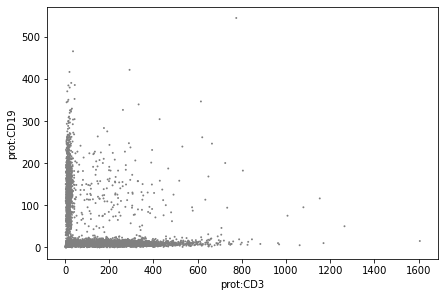

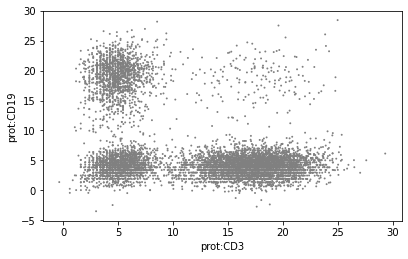

In [22]:
sc.pl.scatter(mdata['prot'], x="prot:CD3", y="prot:CD19", layers='counts')
sc.pl.scatter(mdata['prot'], x="prot:CD3", y="prot:CD19")

#### Downstream analysis

We can run conventional methods like PCA on the normalised protein counts:

In [23]:
sc.tl.pca(prot)

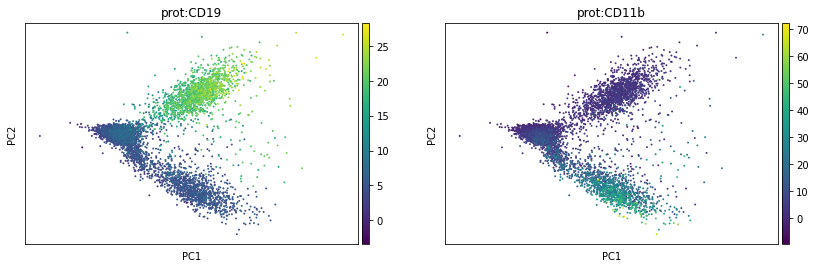

In [24]:
sc.pl.pca(prot, color=['prot:CD19', 'prot:CD11b'])

In [25]:
sc.pp.neighbors(prot)
sc.tl.umap(prot, random_state=1)

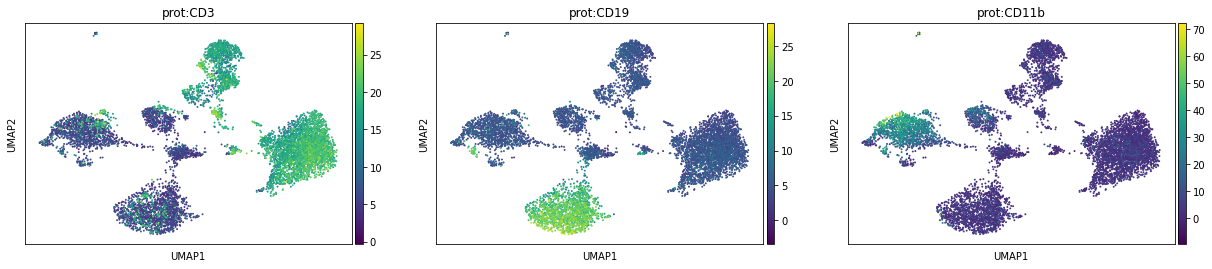

In [26]:
sc.pl.umap(prot, color=['prot:CD3', 'prot:CD19', 'prot:CD11b'])

### RNA modality

In [27]:
rna = mdata.mod['rna']
rna

AnnData object with n_obs × n_vars = 7966 × 36601
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

#### QC

Perform some quality control. For now, we will filter out cells that do not pass QC from the whole dataset.

In [28]:
rna.var['mt'] = rna.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(rna, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

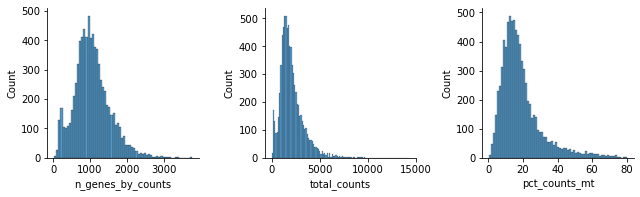

In [29]:
mu.pl.histogram(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'])

Filter genes which expression is not detected:

In [30]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 10)  # gene detected at least in 10 cells

Filter cells:

In [31]:
mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 200) & (x < 2500))

mu.pp.filter_obs(rna, 'total_counts', lambda x: (x > 500) & (x < 5000))
mu.pp.filter_obs(rna, 'pct_counts_mt', lambda x: x < 30)

Let's see how the data looks after filtering:

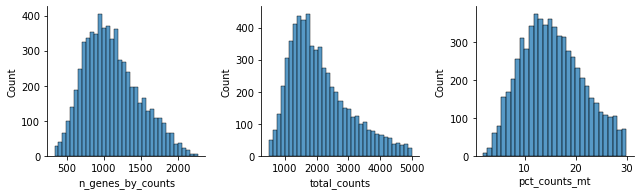

In [32]:
mu.pl.histogram(rna, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'])

#### Normalisation

We'll normalise the data so that we get log-normalised counts to work with.

In [33]:
sc.pp.normalize_total(rna, target_sum=1e4)

In [34]:
sc.pp.log1p(rna)

#### Feature selection

We will label highly variable genes that we'll use for downstream analysis.

In [35]:
sc.pp.highly_variable_genes(rna, min_mean=0.02, max_mean=4, min_disp=0.5)

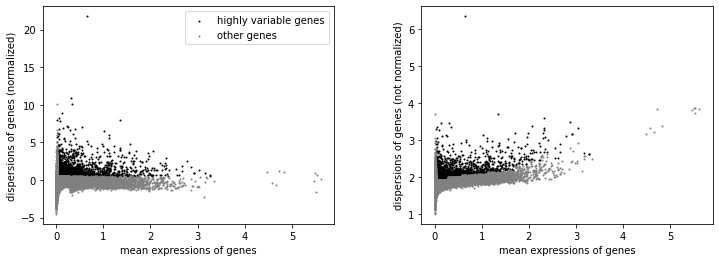

In [36]:
sc.pl.highly_variable_genes(rna)

In [37]:
np.sum(rna.var.highly_variable)

2910

#### Scaling

We'll save log-normalised counts in the `"lognorm"` layer:

In [38]:
rna.layers["lognorm"] = rna.X.copy()

... and scale the log-normalised counts to zero mean and unit variance:

In [39]:
sc.pp.scale(rna, max_value=10)

#### Downstream analysis

Having filtered low-quality cells, normalised the counts matrix, and performed feature selection, we can already use this data for multimodal integration.

It is usually a good idea to study individual modalities first. Moreover, some multimodal methods can utilize principal components space or cell neighbourhood graphs from individual modalities.

Below we run PCA on the scaled matrix, compute cell neighbourhood graph, and perform clustering to define cell types.

##### PCA and neighbourhood graph

In [40]:
sc.tl.pca(rna, svd_solver='arpack')

To visualise the result, we will use some markers for (large-scale) cell populations we expect to see such as T cells and NK cells (CD2), B cells (CD79A), and KLF4 (monocytes).

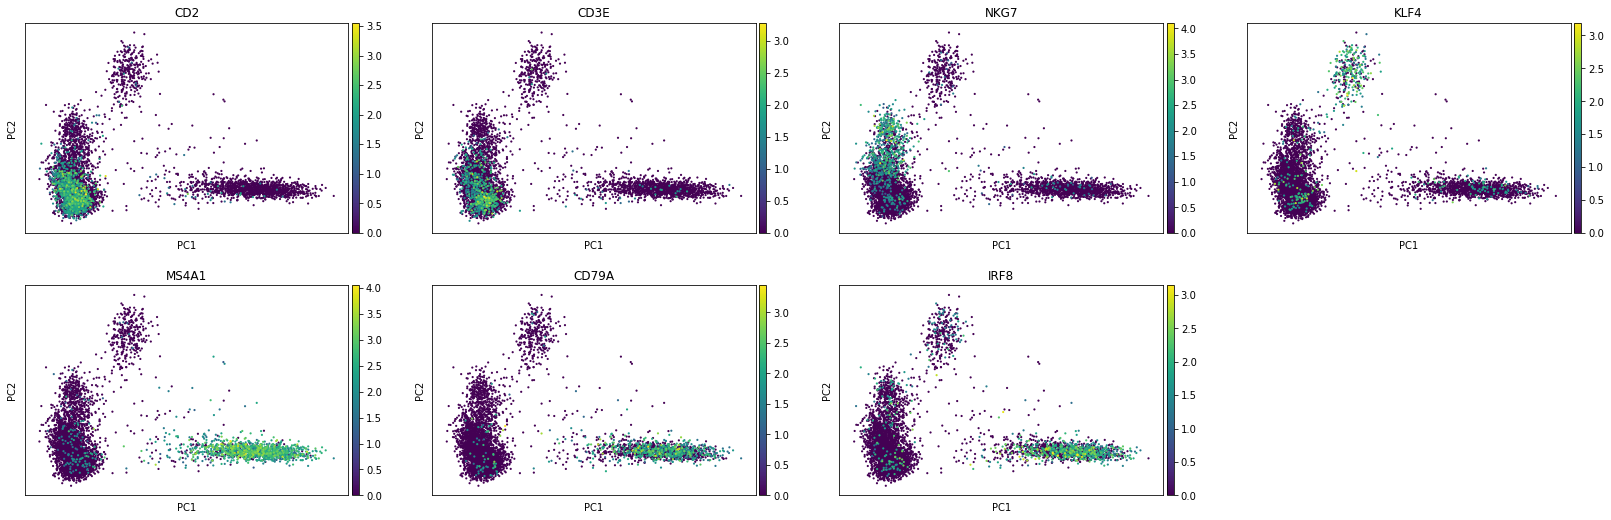

In [41]:
sc.pl.pca(rna, color=['CD2', 'CD3E', 'NKG7', 'KLF4', 'MS4A1', 'CD79A', 'IRF8'], layer="lognorm")

The first principal component (PC1) is separating T/NK (left), myeloid (middle), and B (right) cells while monocyte-related features seem to drive the second one. Also we see plasmocytoid dendritic cells (marked by IRF8) being close to B cells in the PC1/PC2 space.

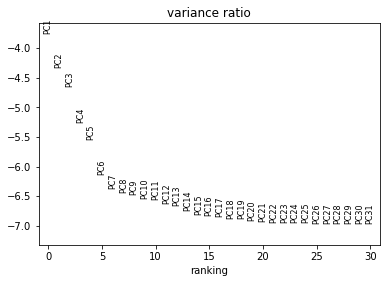

In [42]:
sc.pl.pca_variance_ratio(rna, log=True)

Now we can compute a neighbourhood graph for cells:

In [43]:
sc.pp.neighbors(rna, n_neighbors=10, n_pcs=20)

##### Non-linear dimensionality reduction and clustering

With the neighbourhood graph computed, we can now perform clustering. We will use `leiden` clustering as an example.

In [44]:
sc.tl.leiden(rna, resolution=.75)

To visualise the results, we'll first generate a 2D latent space with cells that we can colour according to their cluster assignment.

In [45]:
sc.tl.umap(rna, spread=1., min_dist=.5, random_state=11)

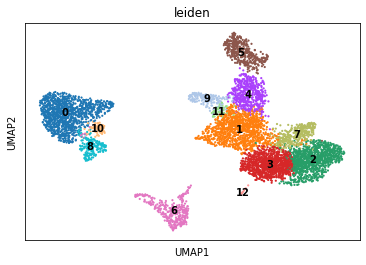

In [46]:
sc.pl.umap(rna, color="leiden", legend_loc="on data")

#### Plotting across modalities

With `mu.pl.embedding` interface we can display an embedding from an individual modality (e.g. `'rna'`) and colour cells by a feature (variable) from another modality.

While variables names should be unique across all modalities, all individual modalities as well as the `mdata` object itself can have e.g. UMAP basis computed. To point to a basis from a specific modality, use `mod:basis` syntax, e.g. with `"rna:X_umap"` in the example below `mdata.mod['rna'].obsm["X_umap"]` basis is going to be used. 

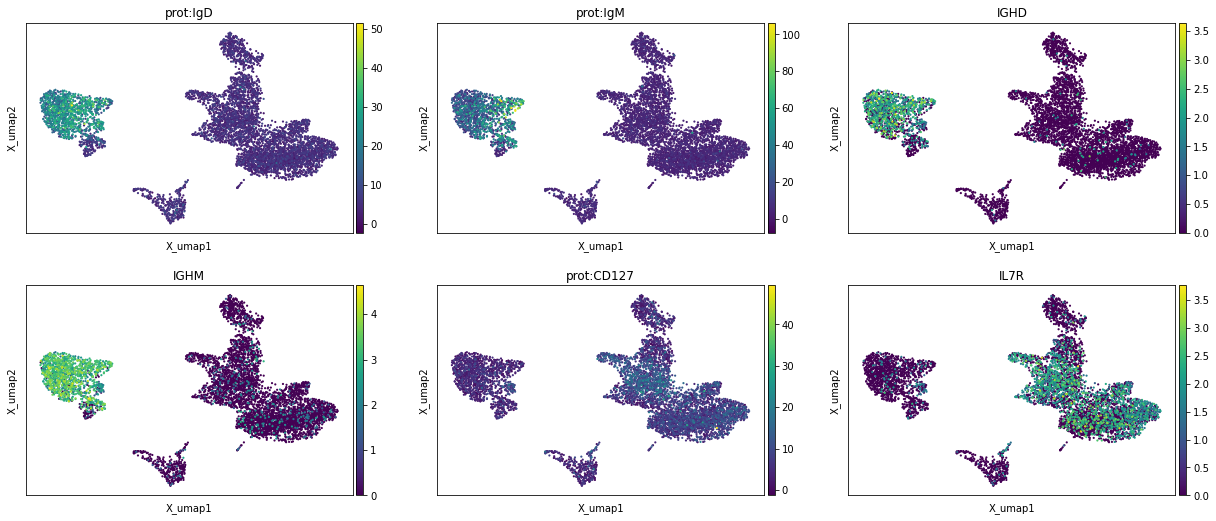

In [48]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["prot:IgD", "prot:IgM", "IGHD", "IGHM", "prot:CD127", "IL7R"], layer={"rna": "lognorm"}, ncols=3)

### ATAC modality

In [49]:
atac = mdata['atac']
atac

AnnData object with n_obs × n_vars = 7966 × 101554
    var: 'gene_ids', 'feature_types', 'genome', 'interval'

Locate the fragments file (use `tabix -p bed` to generate an index file for it):

In [50]:
ac.tl.locate_fragments(atac, f"{data_dir}/{s}_X066-MP0C1{w}_leukopak_perm-cells_tea_200M_atac_filtered_fragments.tsv.gz")

Adding metadata to the ATAC modality:

In [51]:
metadata = pd.read_csv(f"{data_dir}/{s}_X066-MP0C1{w}_leukopak_perm-cells_tea_200M_atac_filtered_metadata.csv.gz")
pd.set_option('display.max_columns', 500)
metadata.head()

,original_barcodes,n_fragments,n_duplicate,n_mito,n_unique,altius_count,altius_frac,gene_bodies_count,gene_bodies_frac,peaks_count,peaks_frac,tss_count,tss_frac,barcodes,cell_name,well_id,chip_id,batch_id,pbmc_sample_id,DoubletScore,DoubletEnrichment,TSSEnrichment
0,GTGTGAGCATGCTATG-1,38760,17870,2,17316,13692,0.790714,11785,0.680584,10043,0.579984,5100,0.294525,69c6c7c43ef411ebb8b442010a19c80f,unblacked_accurate_myotis,X066-AP0C1W3,X066-AP0C1,X066,X066-Well3,0.000000,0.257143,8.046
1,TCACCGGCACAGAACG-1,12820,7294,12,4291,3751,0.874155,3128,0.728968,3159,0.736192,2194,0.511303,69c7d3ee3ef411ebb8b442010a19c80f,fabulous_panphobic_tahr,X066-AP0C1W3,X066-AP0C1,X066,X066-Well3,0.000000,0.114286,8.997
2,AAAGGACGTACAATGT-1,16117,9524,0,4989,4561,0.914211,3602,0.721988,3863,0.774303,2828,0.566847,69be295c3ef411ebb8b442010a19c80f,tricky_anaemic_mayfly,X066-AP0C1W3,X066-AP0C1,X066,X066-Well3,0.000000,0.085714,11.081
3,CAGCCTAAGACAACAG-1,44967,24156,0,17456,15918,0.911893,12033,0.689333,13724,0.786205,7241,0.414814,69c161123ef411ebb8b442010a19c80f,agonizing_haughty_collie,X066-AP0C1W3,X066-AP0C1,X066,X066-Well3,2.351825,1.828571,12.804
4,ACTCGCTTCCAGGAAA-1,16526,8896,0,6227,5584,0.896740,4286,0.688293,4747,0.762325,2658,0.426851,69bf6b003ef411ebb8b442010a19c80f,exorcistic_harmonic_bushbaby,X066-AP0C1W3,X066-AP0C1,X066,X066-Well3,0.000000,1.400000,21.016


In [52]:
atac.obs = atac.obs.join(metadata.set_index("original_barcodes"))

Please note this metadata is available for the filtered (after QC) ATAC data so this modality can be just filtered using these cells.

For demonstration purposes we will still go through processing steps before removing barcodes that were filtered out.

#### QC

Perform some quality control filtering out cells with too few peaks and peaks detected in too few cells. For now, we will filter out cells that do not pass QC.

In [53]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

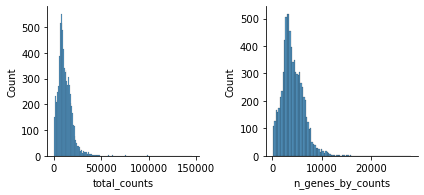

In [54]:
mu.pl.histogram(atac, ['total_counts', 'n_genes_by_counts'])

Filter peaks which expression is not detected:

In [55]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 5)  # a peak is detected in 5 cells or more

Filter cells:

In [56]:
mu.pp.filter_obs(atac, 'total_counts', lambda x: (x >= 1000) & (x <= 30000))

mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 500) & (x <= 10000))  # number of peaks per cell

Let's see how the data looks after filtering:

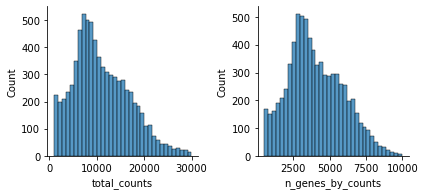

In [57]:
mu.pl.histogram(atac, ['total_counts', 'n_genes_by_counts'])

There are a few expectations about how ATAC-seq data looks like as noted [in the hitchhiker’s guide to ATAC-seq data analysis](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1929-3#citeas) for instance.

##### Nucleosome signal

Fragment size distribution typically reflects nucleosome binding pattern showing enrichment around values corresponding to fragments bound to a single nucleosome (between 147 bp and 294 bp) as well as nucleosome-free fragments (shorter than 147 bp).

Fetching Regions...: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.19it/s]


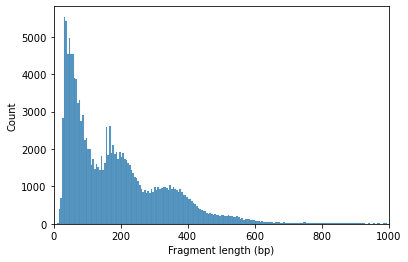

In [58]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000', barcodes="barcodes")

The ratio of mono-nucleosome cut fragments to nucleosome-free fragments can be called *nucleosome signal*, and it can be estimated using a subset of fragments.

In [59]:
ac.tl.nucleosome_signal(atac, n=1e6, barcodes="barcodes")

Reading Fragments: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:06<00:00, 149011.41it/s]


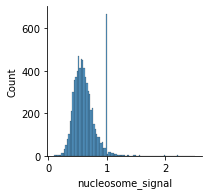

In [60]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

##### TSS enrichment

We can expect chromatin accessibility enriched around transcription start sites (TSS) compared to accessibility of flanking regions. Thus this measure averaged across multiple genes can serve as one more quality control metric.

The positions of transcription start sites can be obtained from the `interval` field of the gene annotation in the `rna` modality:

In [61]:
ac.tl.get_gene_annotation_from_rna(mdata['rna']).head(3)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
LINC01409,chr1,778757,803934,ENSG00000237491,LINC01409
LINC01128,chr1,827597,860227,ENSG00000228794,LINC01128


TSS enrichment function will return an AnnData object with `cells x bases` dimensions where `bases` correspond to positions around TSS and are defined by `extend_upstream` and `extend_downstream` parameters, each of them being 1000 bp by default. It will also record `tss_score` in the original object.

In [62]:
tss = ac.tl.tss_enrichment(mdata, n_tss=1000, barcodes="barcodes")  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 61.24it/s]


In [63]:
tss

AnnData object with n_obs × n_vars = 7639 × 2001
    obs: 'n_fragments', 'n_duplicate', 'n_mito', 'n_unique', 'altius_count', 'altius_frac', 'gene_bodies_count', 'gene_bodies_frac', 'peaks_count', 'peaks_frac', 'tss_count', 'tss_frac', 'barcodes', 'cell_name', 'well_id', 'chip_id', 'batch_id', 'pbmc_sample_id', 'DoubletScore', 'DoubletEnrichment', 'TSSEnrichment', 'n_genes_by_counts', 'total_counts', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

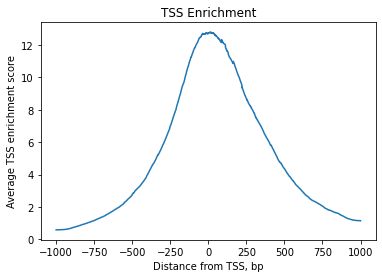

In [64]:
ac.pl.tss_enrichment(tss)

Now we'll remove the barcodes that were filtered out as indicated in the provided metadata.

In [65]:
# To avoid issues with nan being converted to 'nan' when the column is categorical,
# we explicitely convert it to str
mu.pp.filter_obs(atac, atac.obs.barcodes.astype(str) != 'nan')

#### Normalisation

In [66]:
# Save original counts
atac.layers["counts"] = atac.X

There can be multiple options for ATAC-seq data normalisation such as LSI that uses TF-IDF transformation.

Here we will use the same log-normalisation and PCA that we are used to from scRNA-seq analysis.

In [67]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

#### Feature selection

We will label highly variable peaks that we'll use for downstream analysis.

In [68]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

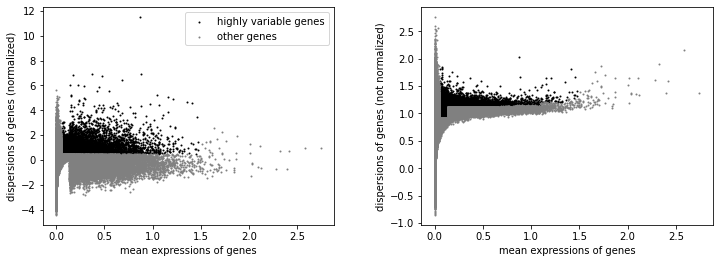

In [69]:
sc.pl.highly_variable_genes(atac)

In [70]:
np.sum(atac.var.highly_variable)

10867

#### Scaling

We'll save log-transformed counts in the `"lognorm"` layer:

In [71]:
atac.layers["lognorm"] = atac.X.copy()

#### Downstream analysis

##### PCA

For this notebook, we are using PCA on the log-normalised counts in `atac.X` as described above.

In [72]:
sc.pp.scale(atac)
sc.tl.pca(atac)

We can only colour our plots by cut counts in individual peaks with scanpy:

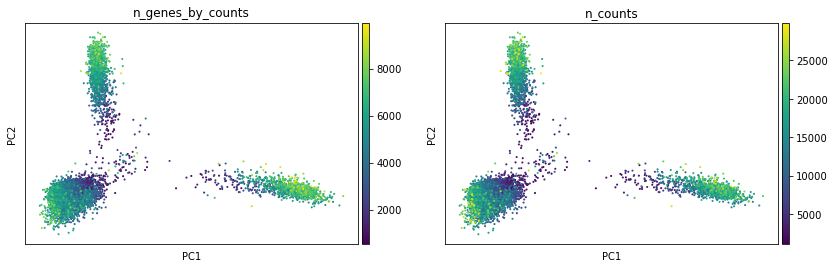

In [73]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"], layer="lognorm")

Now we will compute a neighbourhood graph for cells that we'll use for clustering later on.

In [74]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

##### Non-linear dimensionality reduction and clustering

To stay comparable to the gene expression notebook, we will use `leiden` to cluster cells.

In [75]:
sc.tl.leiden(atac, resolution=.5)

We'll use UMAP latent space for visualisation below.

In [76]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=30)

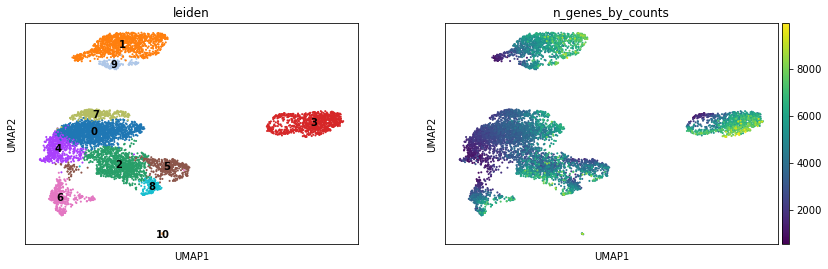

In [77]:
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

## Multi-omics analyses

For the downstream multimodal analysis, we will use only cells passing QC steps in each of the modality. Since cells were filtered out in each modality above, we can just take their intersection:

In [78]:
mu.pp.intersect_obs(mdata)

### Multiplex clustering

We can run clustering based on neighbours information from each modality taking advantage of multiplex versions of algorithms such as `leiden` or `louvain`.

In [79]:
mdata.uns = dict()

In [80]:
mu.tl.leiden(mdata, resolution=[1., 1., 1.], random_state=1, key_added="leiden_multiplex")

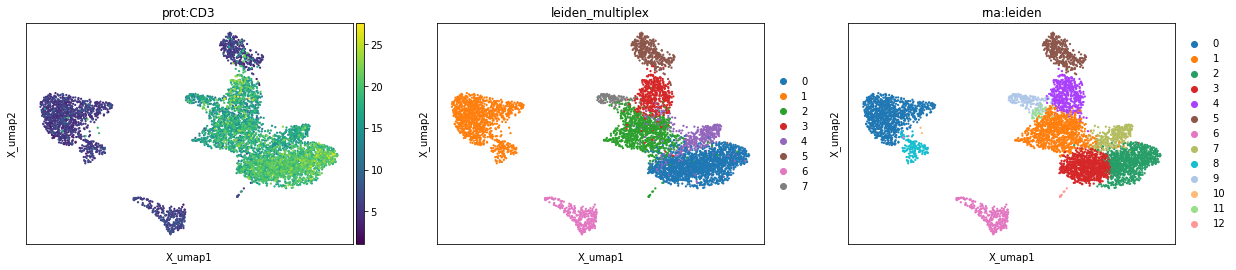

In [85]:
mu.pl.embedding(mdata, basis="rna:X_umap", color=["prot:CD3", "leiden_multiplex", "rna:leiden"])

### Multi-omics factor analysis

To generate an interpretable latent space for all three modalities, we will now run **multi-omic factor analysis** — a group factor analysis method that will allow us to learn an interpretable latent space jointly on both modalities. Intuitively, it can be viewed as a generalisation of PCA for multi-omics data. More information about this method can be found [on the MOFA website](https://biofam.github.io/MOFA2/).

In [86]:
prot.var["highly_variable"] = True
mdata.update()

In [88]:
mu.tl.mofa(mdata, outfile="models/pbmc_w3_teaseq.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='rna' group='group1' with N=5805 samples and D=2910 features...
Loaded view='atac' group='group1' with N=5805 samples and D=10867 features...
Loaded view='prot' group='group1' with N=5805 samples and D=46 features...


Model options:
- Automatic Relevance Determination prior on the factors: True
- Automatic Relevance Determination prior on the weights: True
- Spike-a

This adds `X_mofa` embeddings to the `.obsm` slot of the `MuData` object itself. The weights for the latent factors are stored in `.varm["LFs"]`.

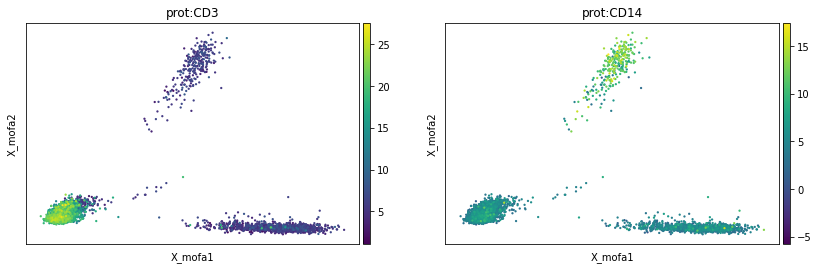

In [89]:
mu.pl.mofa(mdata, color=['prot:CD3', 'prot:CD14'])

MOFA factors can be used to define cell neighbourhood graphs, which are thus based on all the modalities, as well as for subsequent non-linear latent space construction such as UMAP and clustering.

In [90]:
sc.pp.neighbors(mdata, use_rep="X_mofa", key_added='mofa')
sc.tl.umap(mdata, min_dist=.2, random_state=1, neighbors_key='mofa')

In [130]:
sc.tl.leiden(mdata, resolution=.3, neighbors_key='mofa', key_added='leiden_mofa')

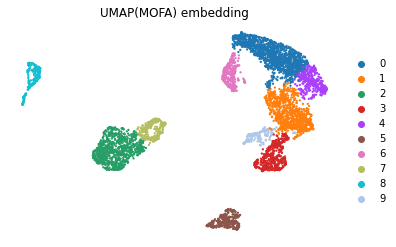

In [131]:
mu.pl.umap(mdata, color=['leiden_mofa'], frameon=False, title="UMAP(MOFA) embedding")

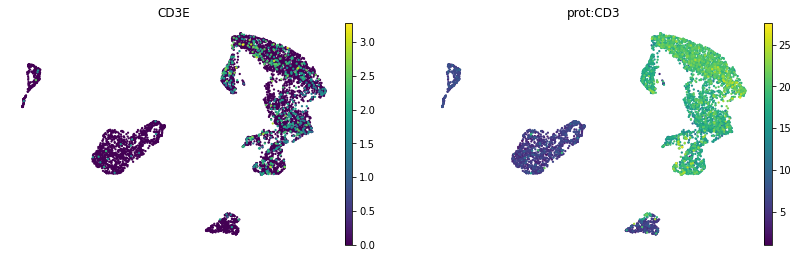

In [93]:
mu.pl.umap(mdata, color=['CD3E', 'prot:CD3'], layer={"rna": "lognorm"}, frameon=False, cmap='viridis')

In [95]:
mdata.obsm["X_mofa_umap"] = mdata.obsm["X_umap"].copy()

#### Interpreting the model

We can describe factors by the top features, which they are defined by.

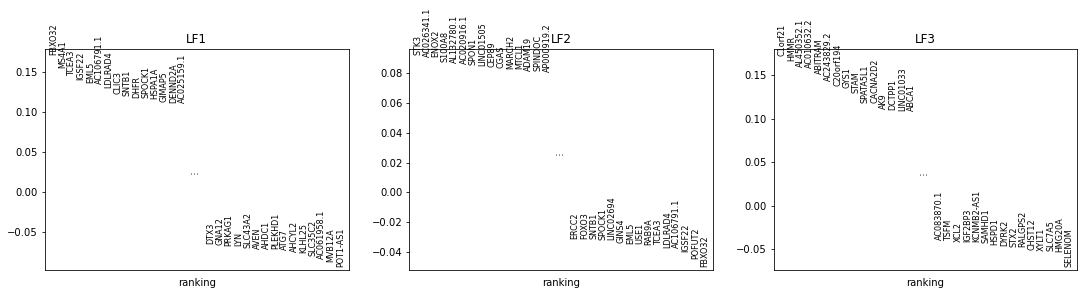

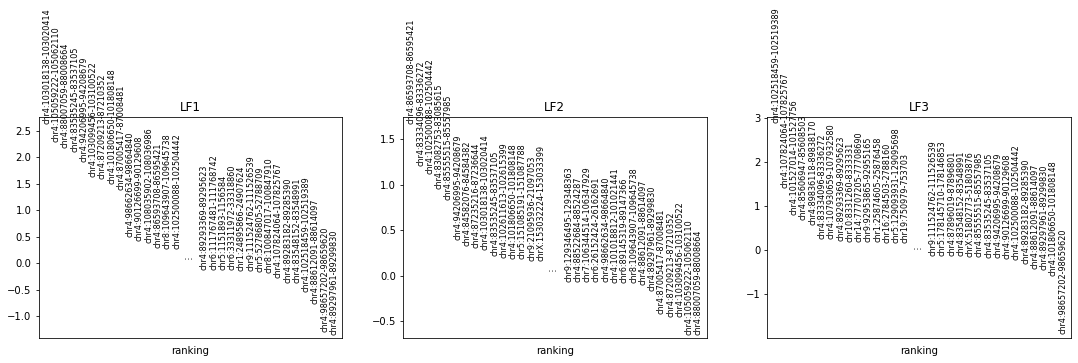

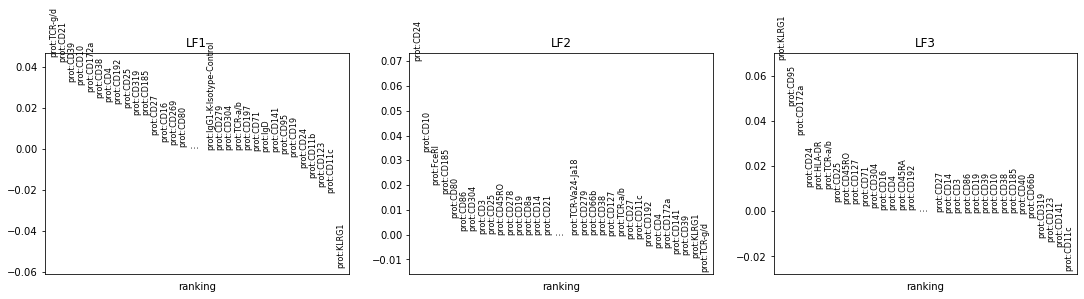

In [96]:
mu.pl.mofa_loadings(mdata)

More detailed analysis of the MOFA model can be done with `mofax`, which is available [here](https://github.com/bioFAM/mofax), using the model file saved during the training above.

### Weighted nearest neighbours

Another way to leverage multimodal information is with the **weighted nearest neighbours** (WNN) method, which constructs a multimodal cell neighbourhood graph based on cell neighbourhood graphs of individual modalities. `muon` implements WNN as it is described in [Hao et al., 2020]() with the generalisation to an arbitrary number of modalities proposed in [Swanson et al., 2021](https://elifesciences.org/articles/63632).

For this to work, we'll have to re-calculate neighbourhood in each modality because we have filtered out cells after that had been done above. That usually leads to having cells with no neighbours, and `muon` will be explicit about it and will return an error.

In [97]:
for m in mdata.mod.keys():
    sc.pp.neighbors(mdata[m])

In [98]:
mu.pp.neighbors(mdata, key_added='wnn')

Again, we can use the defined cell neighbours to perform clustering or non-linear dimensionality reduction.

In [145]:
sc.tl.leiden(mdata, resolution=.55, neighbors_key='wnn', key_added='leiden_wnn')

In [148]:
mu.tl.umap(mdata, random_state=10, neighbors_key='wnn')

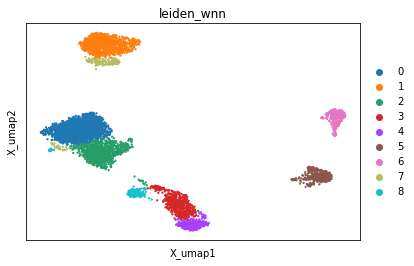

In [149]:
mu.pl.umap(mdata, color="leiden_wnn")

In [150]:
mdata.obsm["X_wnn_umap"] = mdata.obsm["X_umap"].copy()

### Cell types annotation

We can use the results of any multiple multimodal analyses — or multiple ones — to define cell types. Alternatively, cell types can be defined using a single modality, e.g. `'prot'`, and the cell types labels robustness can then be checked with multimodal embeddings.

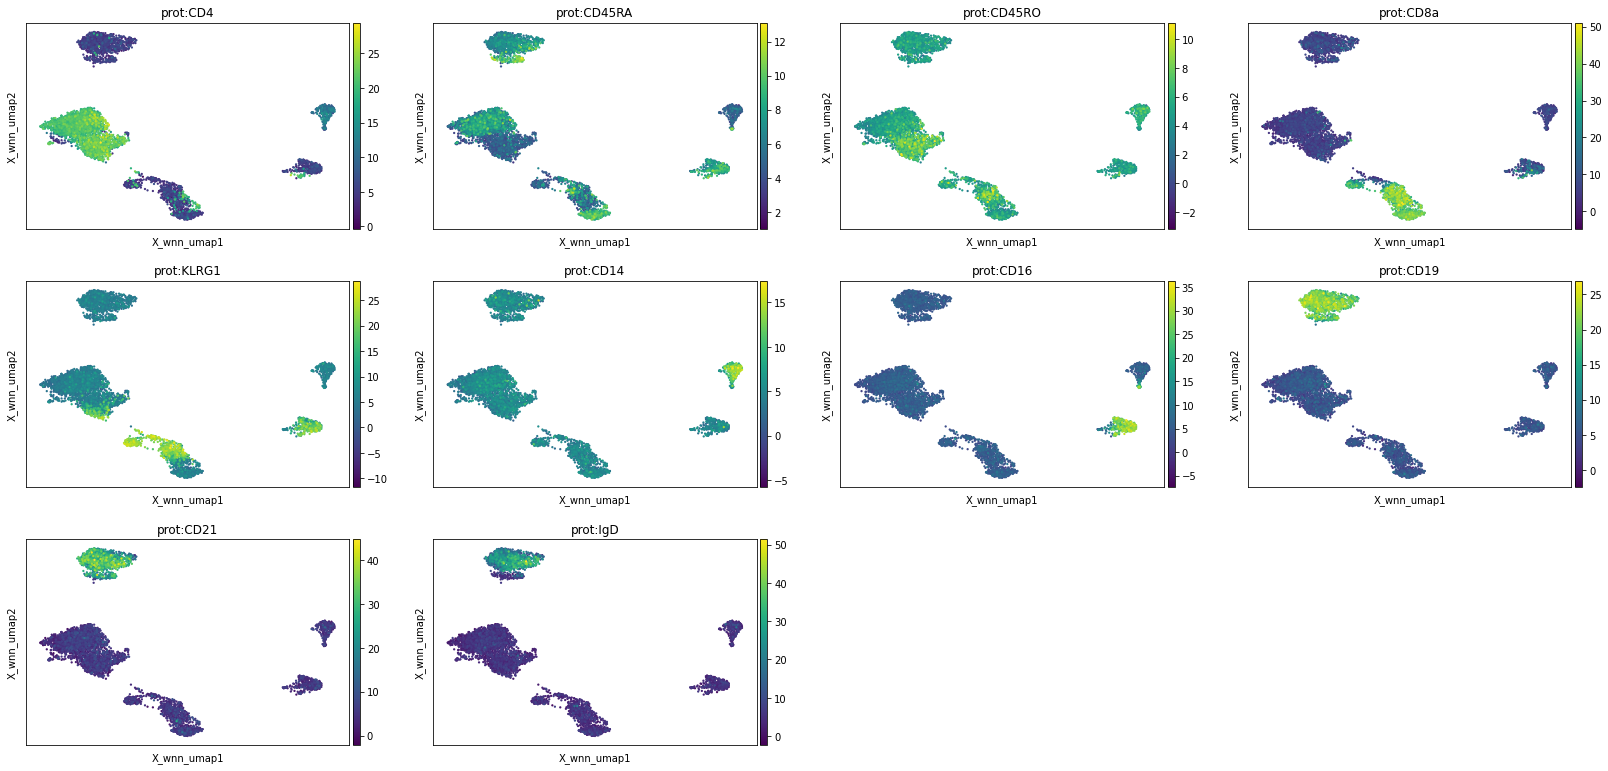

In [151]:
mu.pl.embedding(mdata, basis="X_wnn_umap", color=list(map(
    lambda x: "prot:" + x,
    [
        "CD4", "CD45RA", "CD45RO",  # CD4 T cells
        "CD8a",                     # CD8 T cells
        "KLRG1",                    # NK cells
        "CD14", "CD16",             # monocytes
        "CD19", "CD21", "IgD",      # B cells
    ]
)))

Label clusters according to the markers:

In [155]:
new_cluster_names = {
    "0": "naïve CD4+ T", "1": "naïve B", "2": "memory CD4+ T",
    "4": "naïve CD8+ T", "3": "effector CD8+ T", "5": "CD16 mono",
    "6": "CD14 mono", "7": "active B", "8": "NK",
}

mdata.obs['celltype'] = mdata.obs.leiden_wnn.astype("str").values
mdata.obs.celltype = mdata.obs.celltype.astype("category")
mdata.obs.celltype = mdata.obs.celltype.cat.rename_categories(new_cluster_names)

In [156]:
mdata.obs.celltype.cat.reorder_categories([
    'naïve CD4+ T', 'memory CD4+ T', 'NK', 'effector CD8+ T', 'naïve CD8+ T',
    'naïve B', 'active B',
    'CD14 mono', 'CD16 mono',
], inplace=True)

Add colours:

In [157]:
cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(mdata.obs.celltype.cat.categories)))

mdata.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

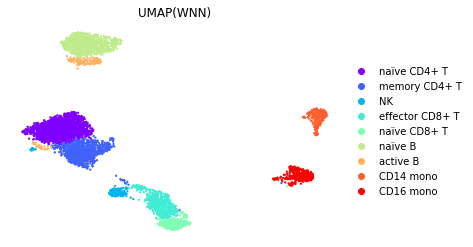

In [158]:
mu.pl.umap(mdata, color="celltype", frameon=False, title="UMAP(WNN)")

## Saving multimodal data on disk

In [159]:
mdata.update()
mdata

rna:n_genes_by_counts,int32,"1375,957,1052,1253,783,681,922,828,1083,1161,998,..."
rna:total_counts,float32,"2509.00,1405.00,1777.00,2399.00,1501.00,1018.00,..."
rna:total_counts_mt,float32,"200.00,119.00,298.00,277.00,448.00,144.00,411.00,..."
rna:pct_counts_mt,float32,"7.97,8.47,16.77,11.55,29.85,14.15,24.49,27.18,..."
rna:leiden,object,"2,2,7,0,8,3,8,3,5,1,0,2,2,2,1,2,6,0,3,0,0,4,4,1,1,..."
atac:n_fragments,float64,"13705.00,11567.00,25610.00,30969.00,16007.00,..."
atac:n_duplicate,float64,"8269.00,6897.00,15043.00,17513.00,8686.00,6703.00,..."
atac:n_mito,float64,"50.00,0.00,0.00,128.00,899.00,4.00,3.00,0.00,0.00,..."
atac:n_unique,float64,"4163.00,3516.00,8395.00,10883.00,4839.00,3152.00,..."
atac:altius_count,float64,"3777.00,3145.00,7613.00,9992.00,4314.00,2806.00,..."
atac:altius_frac,float64,"0.91,0.89,0.91,0.92,0.89,0.89,0.90,0.89,0.89,0.91,..."


We will now write `mdata` object to an `.h5mu` file.

In [163]:
mdata.write(f"{data_dir}/pbmc_w3_teaseq.h5mu", compression="gzip")